# Introduction

In this project, you will build a neural network of your own design to evaluate the CIFAR-10 dataset.

To meet the requirements for this project, you will need to achieve an accuracy greater than 45%. 
If you want to beat Detectocorp's algorithm, you'll need to achieve an accuracy greater than 70%. 
(Beating Detectocorp's algorithm is not a requirement for passing this project, but you're encouraged to try!)

Some of the benchmark results on CIFAR-10 include:

78.9% Accuracy | [Deep Belief Networks; Krizhevsky, 2010](https://www.cs.toronto.edu/~kriz/conv-cifar10-aug2010.pdf)

90.6% Accuracy | [Maxout Networks; Goodfellow et al., 2013](https://arxiv.org/pdf/1302.4389.pdf)

96.0% Accuracy | [Wide Residual Networks; Zagoruyko et al., 2016](https://arxiv.org/pdf/1605.07146.pdf)

99.0% Accuracy | [GPipe; Huang et al., 2018](https://arxiv.org/pdf/1811.06965.pdf)

98.5% Accuracy | [Rethinking Recurrent Neural Networks and other Improvements for ImageClassification; Nguyen et al., 2020](https://arxiv.org/pdf/2007.15161.pdf)

Research with this dataset is ongoing. Notably, many of these networks are quite large and quite expensive to train. 

## Imports

In [1]:
## This cell contains the essential imports you will need – DO NOT CHANGE THE CONTENTS! ##
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms, models
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm

/opt/homebrew/anaconda3/envs/cifar10-classifier/lib/python3.9/site-packages/torchvision/io/image.py:14: UserWarning: Failed to load image Python extension: 'dlopen(/opt/homebrew/anaconda3/envs/cifar10-classifier/lib/python3.9/site-packages/torchvision/image.so, 0x0006): Library not loaded: @rpath/libjpeg.9.dylib
  Referenced from: <FB2FD416-6C4D-3621-B677-61F07C02A3C5> /opt/homebrew/anaconda3/envs/cifar10-classifier/lib/python3.9/site-packages/torchvision/image.so
  Reason: tried: '/opt/homebrew/anaconda3/envs/cifar10-classifier/lib/python3.9/site-packages/torchvision/../../../libjpeg.9.dylib' (no such file), '/opt/homebrew/anaconda3/envs/cifar10-classifier/lib/python3.9/site-packages/torchvision/../../../libjpeg.9.dylib' (no such file), '/opt/homebrew/anaconda3/envs/cifar10-classifier/lib/python3.9/lib-dynload/../../libjpeg.9.dylib' (no such file), '/opt/homebrew/anaconda3/envs/cifar10-classifier/bin/../lib/libjpeg.9.dylib' (no such file)'If you don't plan on using image functionality

## Load the Dataset

Specify your transforms as a list first.
The transforms module is already loaded as `transforms`.

CIFAR-10 is fortunately included in the torchvision module.
Then, you can create your dataset using the `CIFAR10` object from `torchvision.datasets` ([the documentation is available here](https://pytorch.org/docs/stable/torchvision/datasets.html#cifar)).
Make sure to specify `download=True`! 

Once your dataset is created, you'll also need to define a `DataLoader` from the `torch.utils.data` module for both the train and the test set.

In [2]:
# Define transforms
## YOUR CODE HERE ##
# TODO: Define transforms for the training data and testing data
train_transform = transforms.Compose([transforms.Resize((30, 30)),
                                      transforms.RandomHorizontalFlip(), 
                                      transforms.RandomRotation(10),  
                                      transforms.ToTensor(),
                                      transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

validation_test_transform = transforms.Compose([transforms.Resize((30, 30)),
                                         transforms.ToTensor(),
                                         transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

# Create training set and define training dataloader
## YOUR CODE HERE ##
# Download and load the training data
trainset = datasets.CIFAR10(root='CIFAR_10_data/', train=True, download=True)


# Apply simple transformation (conversion to tensor) for the view set to create a view loader 
viewset = datasets.CIFAR10(root='CIFAR_10_data/', train=True, download=False)
viewset.transform = transforms.ToTensor()
viewloader = torch.utils.data.DataLoader(viewset, batch_size=64, shuffle=True)
                      
# Split the dataset into training and validation sets
train_size = int(0.8 * len(trainset))  # 80% for training
validation_size = len(trainset) - train_size  # 20% for validation
train_subset, validation_subset = torch.utils.data.random_split(trainset, [train_size, validation_size])

# Apply transformations to train and validation sets
train_subset.dataset.transform = train_transform
validation_subset.dataset.transform = validation_test_transform

trainloader = torch.utils.data.DataLoader(train_subset, batch_size=64, shuffle=True)
validationloader = torch.utils.data.DataLoader(validation_subset, batch_size=64, shuffle=True)

# Create test set and define test dataloader
## YOUR CODE HERE ##
testset = datasets.CIFAR10('CIFAR_10_data/', download=True, train=False, transform=validation_test_transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=True)

# The 10 classes in the dataset
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


## Explore the Dataset
Using matplotlib, numpy, and torch, explore the dimensions of your data.

You can view images using the `show5` function defined below – it takes a data loader as an argument.
Remember that normalized images will look really weird to you! You may want to try changing your transforms to view images.
Typically using no transforms other than `toTensor()` works well for viewing – but not as well for training your network.
If `show5` doesn't work, go back and check your code for creating your data loaders and your training/test sets.

In [3]:
def show5(img_loader):
    dataiter = iter(img_loader)
    batch = next(dataiter)
    labels = batch[1][0:5]
    images = batch[0][0:5]
    for i in range(5):
        print(classes[labels[i]])
        image = images[i].numpy()
        plt.imshow(np.rot90(image.T, k=3))
        plt.show()

cat


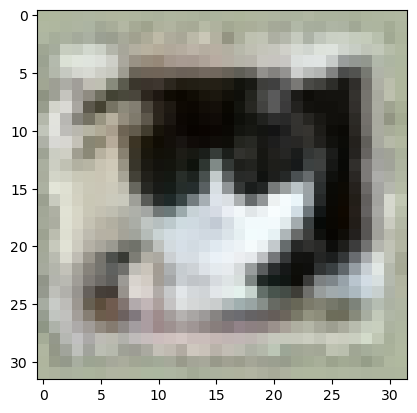

dog


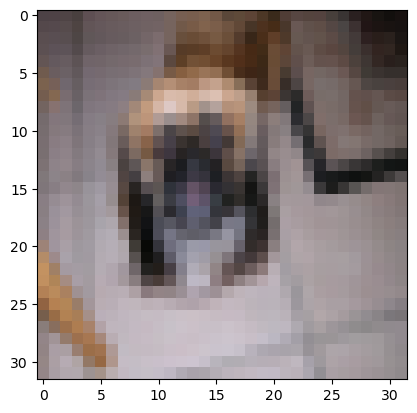

cat


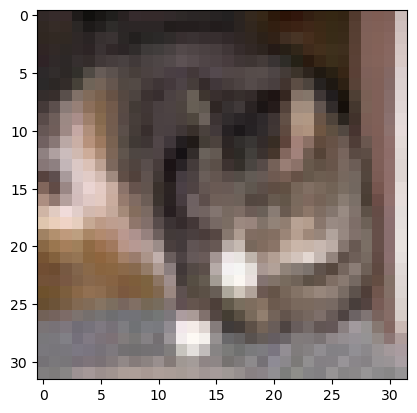

truck


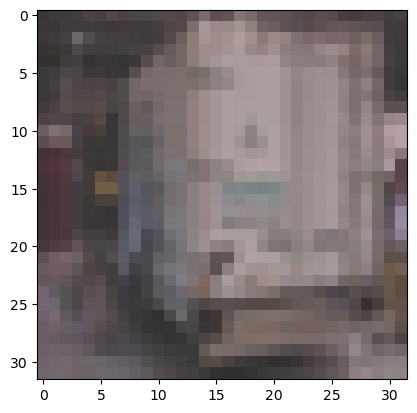

deer


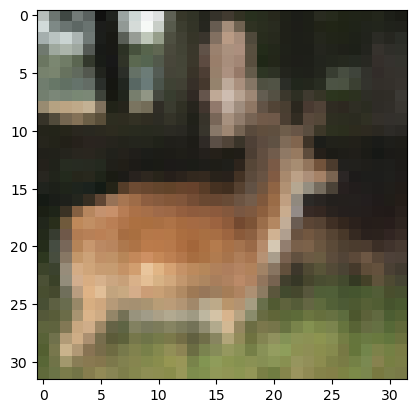

In [4]:
# Explore data
## YOUR CODE HERE ##
show5(viewloader)

## Build your Neural Network
Using the layers in `torch.nn` (which has been imported as `nn`) and the `torch.nn.functional` module (imported as `F`), construct a neural network based on the parameters of the dataset. 
Feel free to construct a model of any architecture – feedforward, convolutional, or even something more advanced!

**Here I used two different models, a simple CNN model, and a complex CNN model with residual blocks**

In [5]:
class CNN(nn.Module):
    def __init__(self, num_classes=10):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=5, stride=1, padding=2)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=5, stride=1, padding=2)
        self.conv3 = nn.Conv2d(32, 64, kernel_size=5, stride=1, padding=2)
        
        # Update the input size of the first fully connected layer
        self.fc1 = nn.Linear(64 * 3 * 3, 2048)  # 64 channels * 3x3 feature map
        self.fc2 = nn.Linear(2048, 1024)
        self.fc3 = nn.Linear(1024, num_classes)
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = self.dropout(x)
        x = self.fc3(x)
        return F.log_softmax(x, dim=1)

In [6]:
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1, downsample=None):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.downsample = downsample

    def forward(self, x):
        identity = x

        if self.downsample is not None:
            identity = self.downsample(x)

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)
        out += identity
        out = self.relu(out)

        return out

class ResCNN(nn.Module):
    def __init__(self, num_classes=10):
        super(ResCNN, self).__init__()
        self.in_channels = 64
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.layer1 = self._make_layer(64, 64, 2, stride=1)
        self.layer2 = self._make_layer(64, 128, 2, stride=2)
        self.layer3 = self._make_layer(128, 256, 2, stride=2)
        self.layer4 = self._make_layer(256, 512, 2, stride=2)
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512, num_classes)

    def _make_layer(self, in_channels, out_channels, blocks, stride):
        downsample = None
        if stride != 1 or in_channels != out_channels:
            downsample = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels),
            )

        layers = []
        layers.append(ResidualBlock(in_channels, out_channels, stride, downsample))
        for _ in range(1, blocks):
            layers.append(ResidualBlock(out_channels, out_channels))

        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)
        return F.log_softmax(x, dim=1)

Specify a loss function and an optimizer, and instantiate the model.

If you use a less common loss function, please note why you chose that loss function in a comment.

In [7]:
## YOUR CODE HERE ##
criterion = nn.NLLLoss()
# Instantiate the simple CNN model
simple_model = CNN(num_classes=10)
print(simple_model)
simple_model_optimizer = optim.Adam(simple_model.parameters(), lr=0.0005)

CNN(
  (conv1): Conv2d(3, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (conv3): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (fc1): Linear(in_features=576, out_features=2048, bias=True)
  (fc2): Linear(in_features=2048, out_features=1024, bias=True)
  (fc3): Linear(in_features=1024, out_features=10, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
)


In [8]:
complex_model = ResCNN(num_classes=10)
print(complex_model)
complex_model_optimizer = optim.Adam(complex_model.parameters(), lr=0.005)

ResCNN(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (layer1): Sequential(
    (0): ResidualBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): ResidualBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.

In [9]:
def predict(image, model, top_k=10):
    preds = torch.exp(model.forward(image))[0]
    sorted_indices = np.argsort(preds)
    top_classes = sorted_indices[-top_k:]
    top_probs = preds[top_classes]
    return top_probs, top_classes

def plot_image(image, top_probs, top_classes, label):
    fig, (ax1, ax2) = plt.subplots(figsize=(6,9), ncols=2)
    ax1.imshow(np.transpose(image, (1, 2, 0)), cmap = plt.cm.binary)
    ax1.axis('off')
    ax1.set_title(classes[label])
    ax2.barh(np.arange(top_probs.shape[0]), top_probs)
    ax2.set_aspect(0.1)
    ax2.set_yticks(np.arange(top_classes.shape[0]))
    ax2.set_yticklabels([classes[key] for key in top_classes], size='small');
    ax2.set_title('Class Probability')
    ax2.set_xlim(0, 1.1)
    plt.tight_layout()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.6784314..0.6392157].


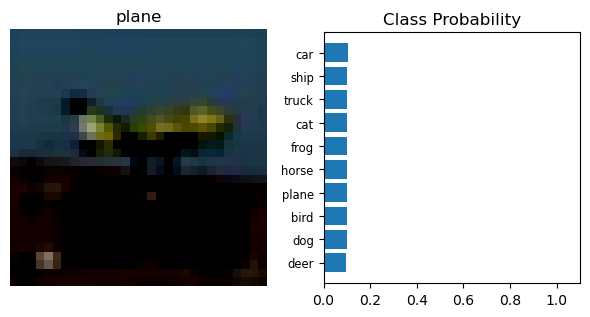

In [10]:
images, labels = next(iter(trainloader))
with torch.no_grad():
    top_probs, top_classes = predict(images, simple_model)
    plot_image(images[0].numpy(), top_probs, top_classes, labels[0])

## Running your Neural Network
Use whatever method you like to train your neural network, and ensure you record the average loss at each epoch. 
Don't forget to use `torch.device()` and the `.to()` method for both your model and your data if you are using GPU!

If you want to print your loss during each epoch, you can use the `enumerate` function and print the loss after a set number of batches. 250 batches works well for most people!

In [11]:
## YOUR CODE HERE ##
import platform

# Comprehensive device detection for optimal performance
def get_optimal_device():
    """
    Detect and return the best available device for training.
    Supports CUDA (NVIDIA), MPS (Apple Silicon), and CPU fallback.
    """
    system_info = platform.system()
    processor = platform.processor()
    
    print(f"🖥️  System: {system_info}")
    print(f"🔧 Processor: {processor}")
    print(f"🐍 Python: {platform.python_version()}")
    print(f"🔥 PyTorch: {torch.__version__}")
    print("-" * 50)
    
    # Check for CUDA (NVIDIA GPU) support
    if torch.cuda.is_available():
        device = torch.device("cuda")
        gpu_count = torch.cuda.device_count()
        gpu_name = torch.cuda.get_device_name(0)
        print(f"🚀 CUDA GPU detected: {gpu_name}")
        print(f"📊 GPU Count: {gpu_count}")
        print(f"💾 GPU Memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.1f} GB")
        return device
    
    # Check for MPS (Apple Silicon) support
    elif torch.backends.mps.is_available():
        device = torch.device("mps")
        print(f"🍎 Apple Silicon MPS acceleration enabled")
        print(f"⚡ Metal Performance Shaders available")
        return device
    
    # Fallback to CPU
    else:
        device = torch.device("cpu")
        cpu_count = torch.get_num_threads()
        print(f"🔄 Using CPU with {cpu_count} threads")
        if system_info == "Darwin":
            print(f"💡 Note: MPS not available on this Mac model")
        elif system_info == "Linux":
            print(f"💡 Note: CUDA not available - install NVIDIA drivers if you have a GPU")
        return device

# Set the optimal device
device = get_optimal_device()
print(f"✅ Selected device: {device}")
print("=" * 50)

def train_model(model, optimizer, trainloader, validationloader, epochs=100, stop_acc=80):
    model.to(device)
    train_losses, val_losses = [], []
    val_acc = []

    for e in range(epochs):
        model.train()    
        running_loss = 0
        for step, (images, labels) in enumerate(tqdm(trainloader, desc=f'Epoch {e+1}/{epochs}', unit='batch')):

            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()

            log_ps = model.forward(images)
            loss = criterion(log_ps, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
        running_loss /= len(trainloader)
        train_losses.append(running_loss)
        # Validating the model
        val_loss, acc = evaluate_model(model, validationloader)
        val_losses.append(val_loss)
        val_acc.append(acc)
        print(f'Training Loss: {running_loss:.3f}, ', 
              f'Validation Loss: {val_loss:.3f}, ',
              f'Validation Accuracy: {acc:.3f}%')
        if acc >= stop_acc:
            break
    return train_losses, val_losses, val_acc

def evaluate_model(model, dataloader):
    # Implement the validation pass and print out the validation accuracy
    loss = 0.0
    correct, total, accuracy = np.zeros(3)
    # turn off gradients
    model.eval()
    # validation pass here
    with torch.no_grad():
        for images, labels in dataloader:   
            images, labels = images.to(device), labels.to(device)
            logits = model.forward(images)
            loss += criterion(logits, labels).item()
            ps = torch.exp(logits)
            _, predicted = torch.max(ps.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
        accuracy = 100 * correct / total
        loss /= len(dataloader)
    return loss, accuracy

🖥️  System: Darwin
🔧 Processor: arm
🐍 Python: 3.9.23
🔥 PyTorch: 2.5.1
--------------------------------------------------
🍎 Apple Silicon MPS acceleration enabled
⚡ Metal Performance Shaders available
✅ Selected device: mps


In [12]:
train_losses, val_losses, val_acc = train_model(simple_model, simple_model_optimizer, trainloader, validationloader, stop_acc=70)

Epoch 1/100: 100%|██████████| 625/625 [00:21<00:00, 29.50batch/s]


Training Loss: 1.632,  Validation Loss: 1.351,  Validation Accuracy: 50.550%


Epoch 2/100: 100%|██████████| 625/625 [00:15<00:00, 41.25batch/s]


Training Loss: 1.247,  Validation Loss: 1.159,  Validation Accuracy: 59.460%


Epoch 3/100: 100%|██████████| 625/625 [00:15<00:00, 39.80batch/s]


Training Loss: 1.066,  Validation Loss: 1.005,  Validation Accuracy: 64.730%


Epoch 4/100: 100%|██████████| 625/625 [00:12<00:00, 48.65batch/s]


Training Loss: 0.945,  Validation Loss: 0.969,  Validation Accuracy: 66.160%


Epoch 5/100: 100%|██████████| 625/625 [00:08<00:00, 73.98batch/s]


Training Loss: 0.843,  Validation Loss: 0.918,  Validation Accuracy: 67.920%


Epoch 6/100: 100%|██████████| 625/625 [00:08<00:00, 74.67batch/s]


Training Loss: 0.754,  Validation Loss: 0.940,  Validation Accuracy: 67.540%


Epoch 7/100: 100%|██████████| 625/625 [00:08<00:00, 74.28batch/s]


Training Loss: 0.677,  Validation Loss: 0.906,  Validation Accuracy: 69.580%


Epoch 8/100: 100%|██████████| 625/625 [00:08<00:00, 74.42batch/s]


Training Loss: 0.605,  Validation Loss: 0.908,  Validation Accuracy: 69.550%


Epoch 9/100: 100%|██████████| 625/625 [00:08<00:00, 74.74batch/s]


Training Loss: 0.539,  Validation Loss: 0.903,  Validation Accuracy: 70.320%


Plot the training loss (and validation loss/accuracy, if recorded).

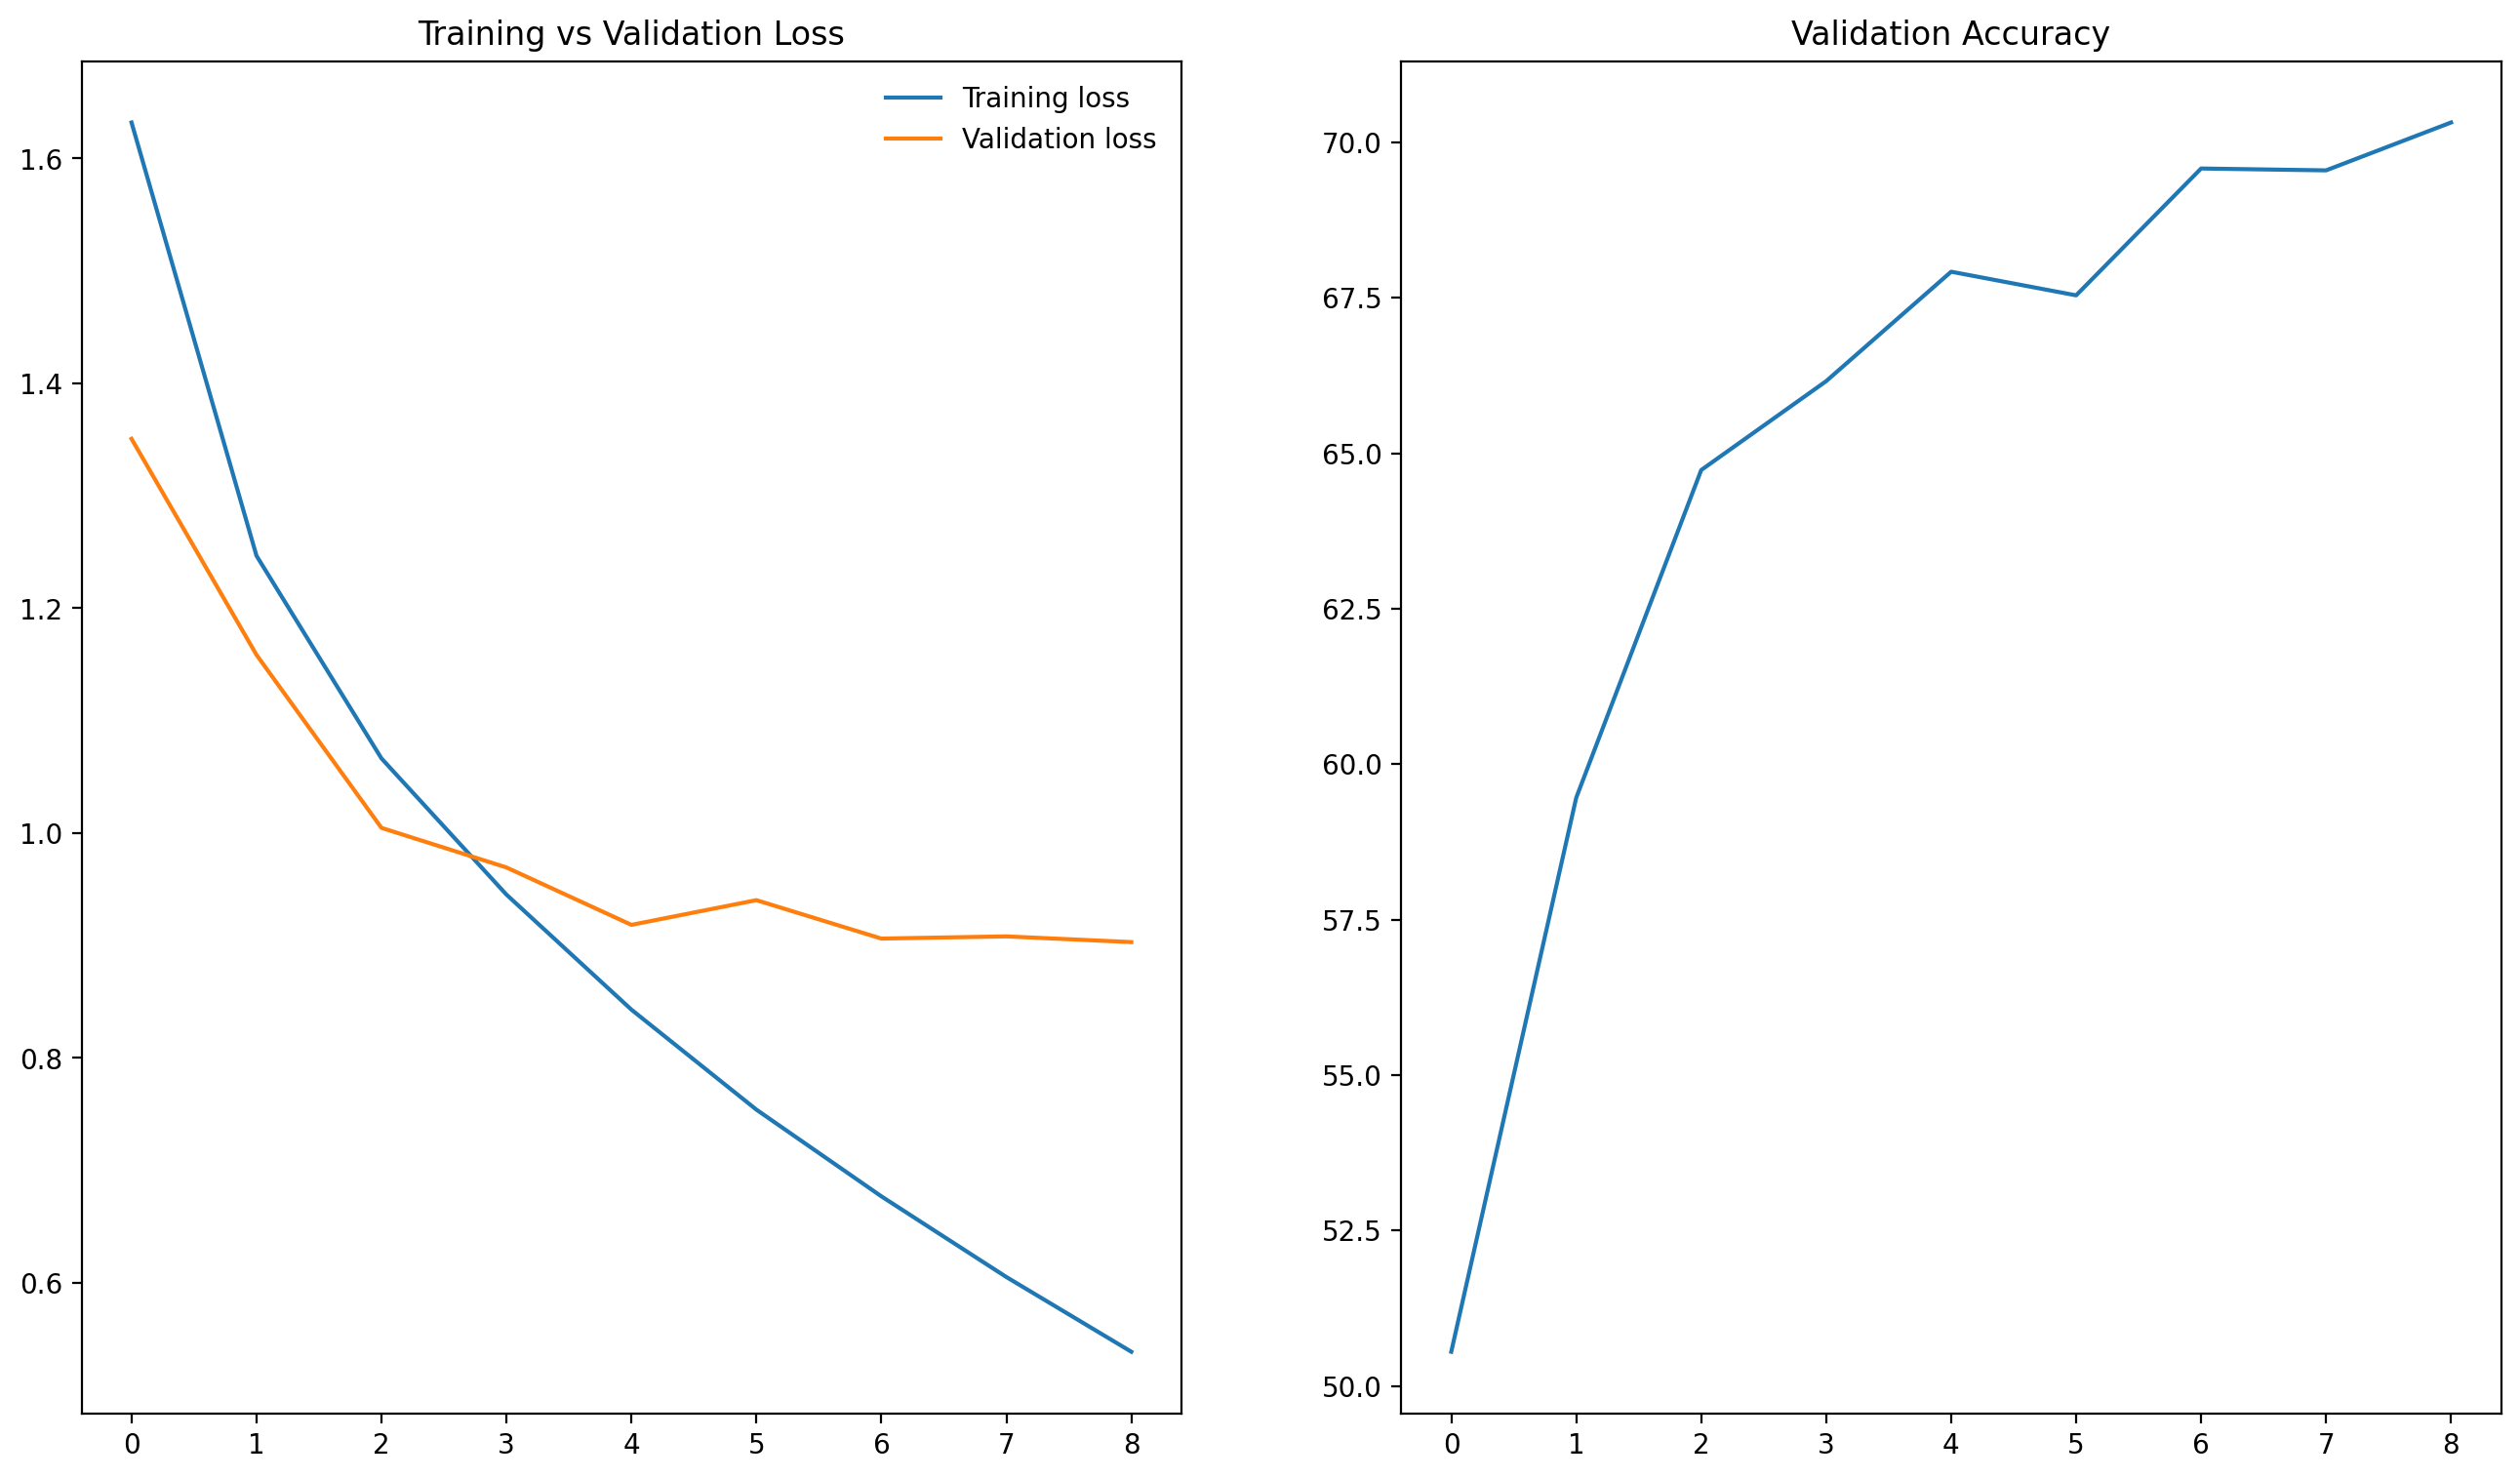

In [13]:
## YOUR CODE HERE ##
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
fig, (ax1, ax2) = plt.subplots(figsize=(16,9), ncols=2)
ax1.set_title('Training vs Validation Loss')
ax1.plot(train_losses, label='Training loss')
ax1.plot(val_losses, label='Validation loss')
ax1.legend(frameon=False)
ax2.set_title('Validation Accuracy')
ax2.plot(val_acc, label='Validation Accuracy')
plt.show()

In [ ]:
train_losses, val_losses, val_acc = train_model(complex_model, complex_model_optimizer, trainloader, validationloader, stop_acc=80)

Epoch 1/100: 100%|██████████| 625/625 [01:01<00:00, 10.24batch/s]


Training Loss: 1.706,  Validation Loss: 1.544,  Validation Accuracy: 44.800%


Epoch 2/100: 100%|██████████| 625/625 [01:13<00:00,  8.56batch/s]


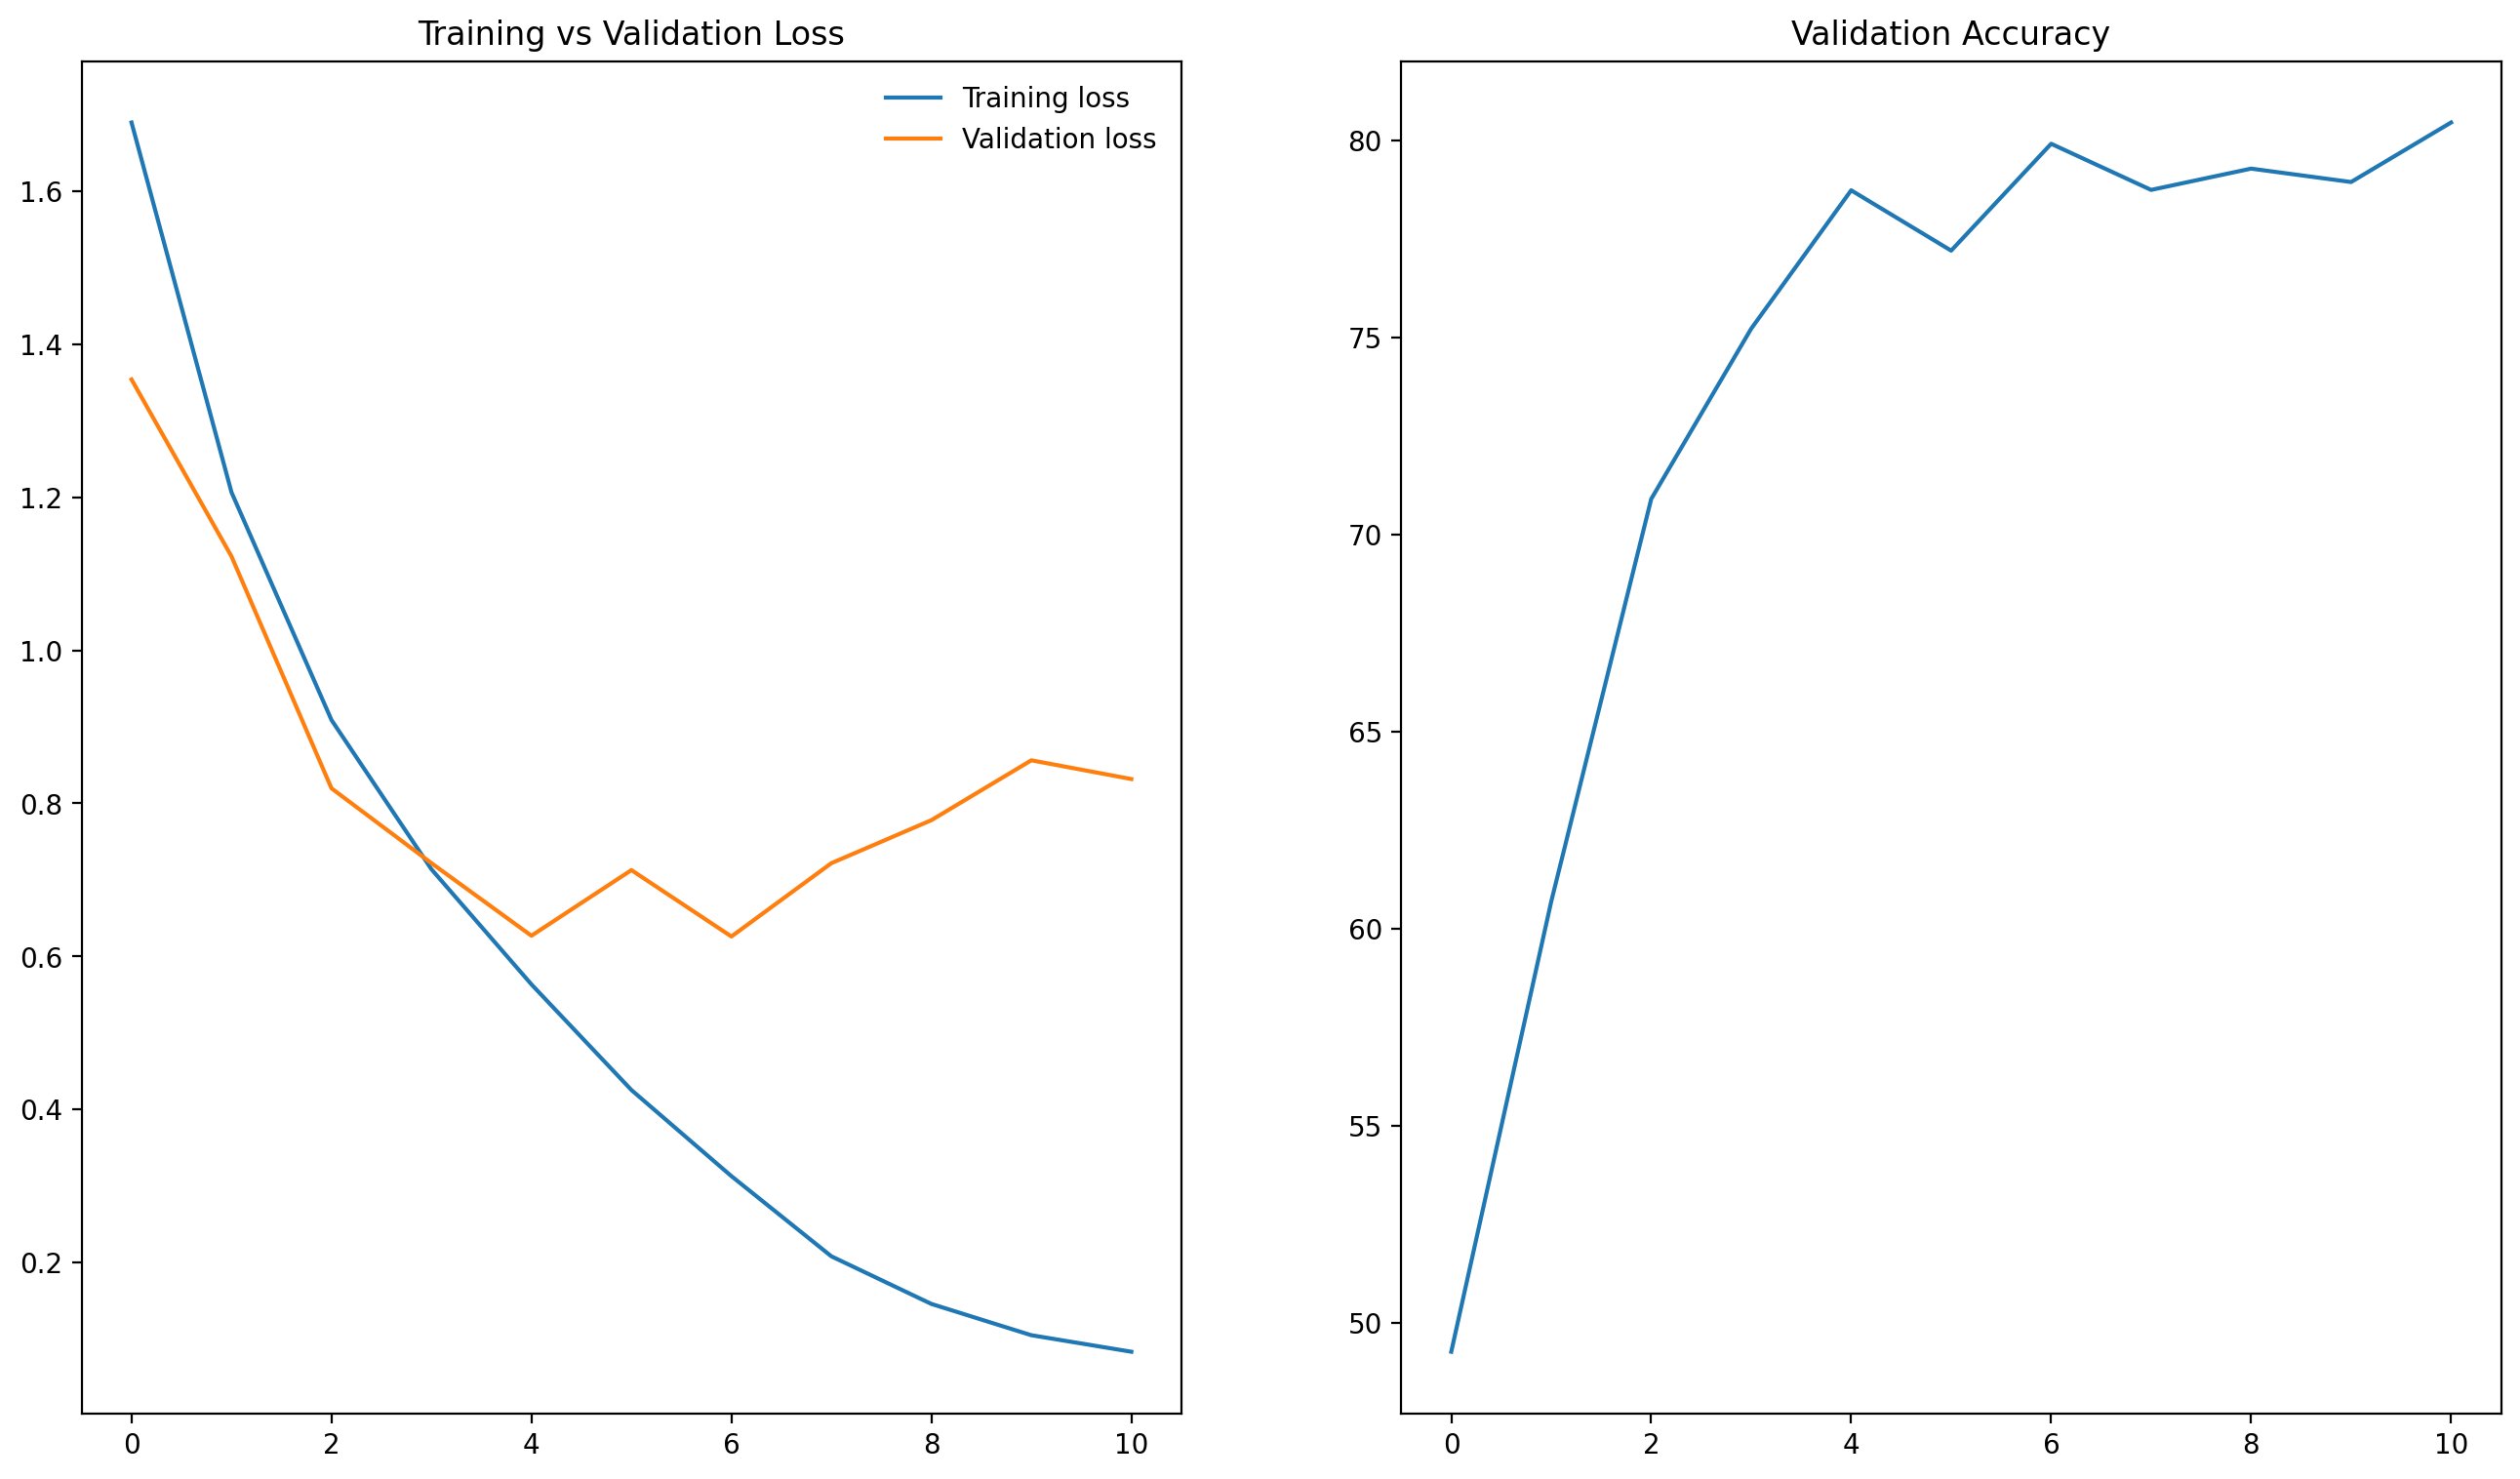

In [ ]:
## YOUR CODE HERE ##
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
fig, (ax1, ax2) = plt.subplots(figsize=(16,9), ncols=2)
ax1.set_title('Training vs Validation Loss')
ax1.plot(train_losses, label='Training loss')
ax1.plot(val_losses, label='Validation loss')
ax1.legend(frameon=False)
ax2.set_title('Validation Accuracy')
ax2.plot(val_acc, label='Validation Accuracy')
plt.show()

## Testing your model
Using the previously created `DataLoader` for the test set, compute the percentage of correct predictions using the highest probability prediction. 

If your accuracy is over 70%, great work! 
This is a hard task to exceed 70% on.

If your accuracy is under 45%, you'll need to make improvements.
Go back and check your model architecture, loss function, and optimizer to make sure they're appropriate for an image classification task.

In [ ]:
## YOUR CODE HERE ##
_, acc = evaluate_model(simple_model, testloader)
print(f'Simple CNN Test Accuracy: {acc:.3f}%')

Simple CNN Test Accuracy: 70.420%


In [ ]:
## YOUR CODE HERE ##
_, acc = evaluate_model(complex_model, testloader)
print(f'Resedual CNN Test Accuracy: {acc:.3f}%')

Resedual CNN Test Accuracy: 79.500%


## Saving your model
Using `torch.save`, save your model for future loading.

In [ ]:
## YOUR CODE HERE ##
torch.save(simple_model, 'cifar10_simple_model.pth')
torch.save(complex_model, 'cifar10_complex_model.pth')

## Make a Recommendation

Based on your evaluation, what is your recommendation on whether to build or buy? Explain your reasoning below.

Some things to consider as you formulate your recommendation:
* How does your model compare to Detectocorp's model?
* How does it compare to the far more advanced solutions in the literature? 
* What did you do to get the accuracy you achieved? 
* Is it necessary to improve this accuracy? If so, what sort of work would be involved in improving it?

### Recommendation: Build or Buy?

**Recommendation: Build**

#### Comparison to Detectocorp's Model:
Both simple and Residual models show promising results, particularly in terms of accuracy. While Detectocorp's benchmark accuracy is around 70%, the models' performance is in a similar range, achieving validation accuracy scores up to 80% based on training results. This suggests that the residual, and even the simple, model is competitive with Detectocorp’s, and with further fine-tuning, it may exceed their performance.

#### Comparison to Advanced Solutions:
When compared to far more advanced solutions in the literature, such as the 96% accuracy achieved by Wide Residual Networks or 99% accuracy from GPipe, my models fall short. However, those models require significantly more computational resources and more advanced architectures, making them costly to implement. In contrast, even the residual model is much lighter and feasible to deploy without the need for massive computing power.

#### Steps Taken to Achieve Accuracy:
To achieve the current level of accuracy, you designed a deep convolutional neural network with residual layers to enhance feature extraction. Key techniques like using batch normalization, max-pooling, dropout, and a complex architecture allowed the model to gradually learn and improve validation accuracy over several epochs.

#### Need for Improvement:
While the current models achieve reasonable accuracy, improving them further may require additional work, such as:
1. **Data Augmentation:** Increasing the diversity of training data can improve the generalization of the model.
2. **Hyperparameter Tuning:** Experimenting with learning rates, optimizers, or batch sizes could improve convergence.
3. **Model Depth or Width:** Increasing the number of residual blocks or fully connected layers could enhance accuracy but at the cost of higher computational complexity.

Thus, given the model's competitive performance and the scalability of improvements, building our own model is a viable approach.

## Submit Your Project

When you are finished editing the notebook and are ready to turn it in, simply click the **SUBMIT PROJECT** button in the lower right.

Once you submit your project, we'll review your work and give you feedback if there's anything that you need to work on. If you'd like to see the exact points that your reviewer will check for when looking at your work, you can have a look over the project [rubric](https://review.udacity.com/#!/rubrics/3077/view).